In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

import re
import unicodedata
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving Elon_musk.csv to Elon_musk (1).csv


In [ ]:
import chardet

with open('Elon_musk.csv','rb') as f:
    data = f.read()
    encoding=chardet.detect(data).get("encoding")
    print(encoding)

Windows-1252


In [ ]:
df = pd.read_csv('Elon_musk.csv',encoding='windows-1252',index_col=0)

In [ ]:
df.head()

,Text
1,@kunalb11 I’m an alien
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...
3,@joerogan @Spotify Great interview!
4,@gtera27 Doge is underestimated
5,@teslacn Congratulations Tesla China for amazi...


In [ ]:
df.shape

(1999, 1)

<Axes: xlabel='Text', ylabel='Count'>

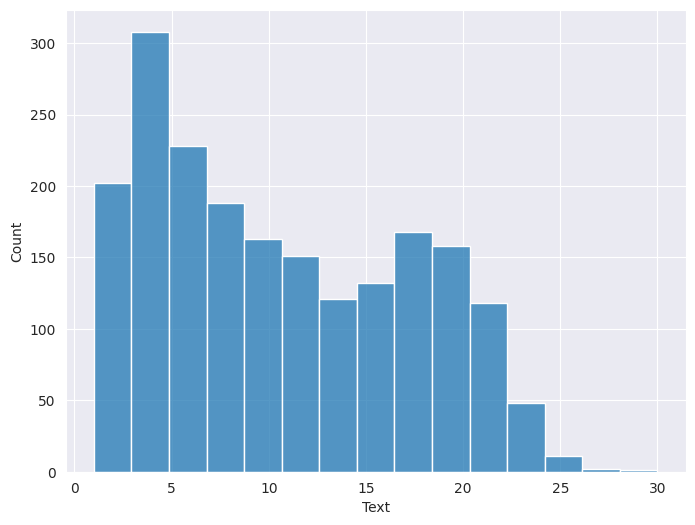

In [ ]:
plt.figure(figsize=(8,6))
word_count = df['Text'].apply(lambda x: len(str(x).split(" ")))
sns.histplot(word_count)

In [ ]:
df['Text'][201]

'RT @SpaceX: Falcon 9’s first stage has landed on the Of Course I Still Love You droneship https://t.co/6gWWlLiXdG'

In [ ]:
df['Text'][1995]

'@flcnhvy True, it sounds so surreal, but the negative propaganda is still all out there &amp; easy to find in social me… https://t.co/WJRzIbKh1H'

<Axes: xlabel='0', ylabel='None'>

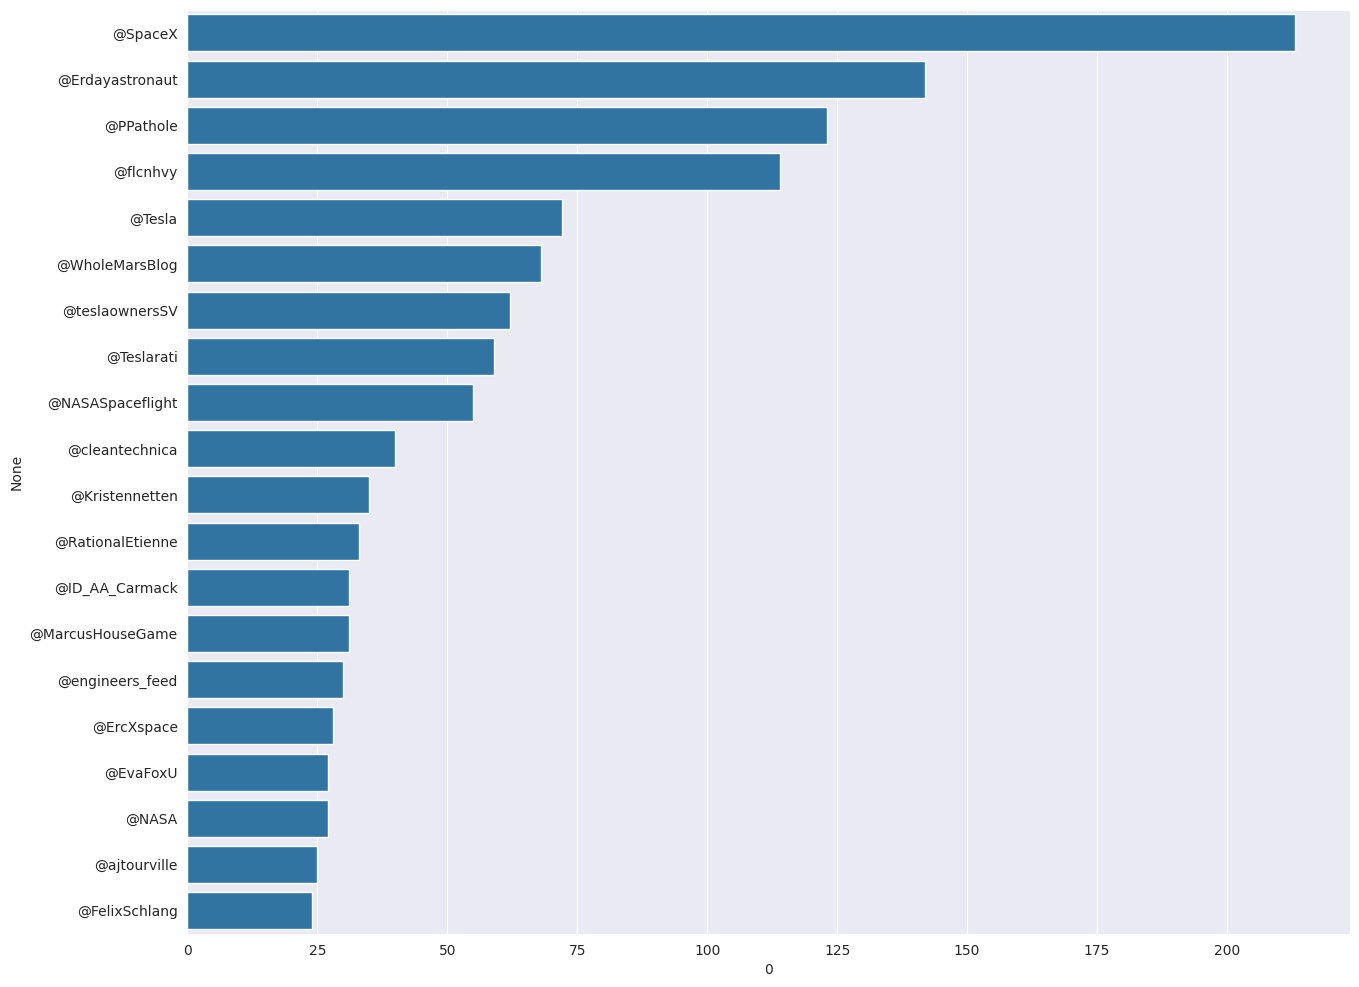

In [ ]:
all_usernames = df['Text'].str.extractall(r'(@\w+)')[0].value_counts()
plt.figure(figsize=(15,12))
sns.barplot(y=all_usernames.head(20).index,x=all_usernames.head(20))

In [ ]:
df['tweet'] = df['Text'].str.replace(r'@\w+\s*','',regex=True).str.strip()

In [ ]:
df['usernames'] = df['Text'].apply(lambda tweet: [word for word in tweet.split() if word.startswith('@')])
df.head()

,Text,tweet,usernames
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11]
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack]
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]"
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27]
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...,[@teslacn]


In [ ]:
df['tweet'].str.contains(r'http[s]?://[^\s]+',regex=True).value_counts()

False    1356
True      643
Name: tweet, dtype: int64

In [ ]:
df['tweet'] = df['tweet'].str.replace(r'http[s]?://[^\s]+','',regex=True).str.strip()
df.head()

,Text,tweet,usernames
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11]
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack]
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]"
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27]
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...,[@teslacn]


In [ ]:
def decode_emojis(text):
    hex_code = re.findall(r'<U\+([0-9A-Fa-f]+)>', text)
    if hex_code:
        code_point = int(hex_code[0],16)
        decoded_text = chr(code_point)
        return unicodedata.name(decoded_text)
    else:
        return np.nan

df['emojis'] = df['tweet'].apply(decode_emojis)

In [ ]:
df['tweet'] = df['tweet'].str.replace(r'<U\+[\w]+>','',regex=True).str.strip()

In [ ]:
df['tweet'] = df['tweet']+' '+df['emojis'].fillna('')
df.head()

,Text,tweet,usernames,emojis
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11],NaN
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack],NaN
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]",NaN
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27],NaN
5,@teslacn Congratulations Tesla China for amazi...,Congratulations Tesla China for amazing execut...,[@teslacn],NaN


In [ ]:
df['tweet'].str.startswith('RT').sum()

127

In [ ]:
df['tweet'] = df['tweet'].str.replace('RT :','').str.strip()

In [ ]:
def extract_named_entities(tweet):
    doc = nlp(tweet)
    entities = [entity.text for entity in doc.ents]
    return entities

name_list = df['tweet'].apply(extract_named_entities)
name_list = [entity for sublist in name_list for entity in sublist]

<Axes: >

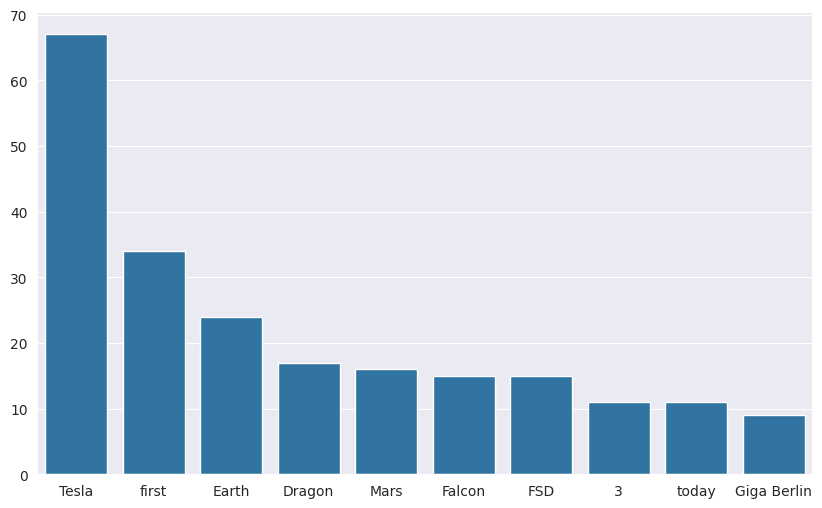

In [ ]:
entity_counts = Counter(name_list)
top_10_names = [entity[0] for entity in entity_counts.most_common(10)]
top_10_counts = [entity[1] for entity in entity_counts.most_common(10)]
plt.figure(figsize=(10,6))
sns.barplot(x=top_10_names,y=top_10_counts)

In [ ]:
def remove_named_entities(text):
    for word in top_10_names:
        return re.sub(word,'',text)

df['tweet'] = df['tweet'].apply(remove_named_entities)

In [ ]:
df['tweet'].str.contains('\n').sum()

40

In [ ]:
df['tweet'].str.contains(r'\[.*?\]').sum()

2

In [ ]:
df['tweet'].str.contains(r'[^\w\s]|[\d]').sum()

1247

In [ ]:
df['cleaned_tweet'] = df['tweet'].str.replace(r"\n|[^\w\s]|[\d]|\[.*?\]",'',regex=True)

In [ ]:
df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()

In [ ]:
from google.colab import files


uploaded = files.upload()

Saving Elon_musk.csv to Elon_musk (2).csv


In [ ]:
stop = stopwords.words('english')

with open('stop.txt') as f:
    extra_stop = [word.strip('\n') for word in f.readlines()]

stop.extend(extra_stop)
stop.extend(['im','ur','et','st','amp','rolling','floor'])

In [ ]:
df['without_stopwords'] = df['cleaned_tweet'].apply(lambda x: [x for x in x.split() if x not in stop])

In [ ]:
lemmatizer = WordNetLemmatizer()
df['lemmatized_tweet'] = df['without_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(i) for i in x]))

In [ ]:
sia = SentimentIntensityAnalyzer()

df['score'] = df['lemmatized_tweet'].apply(lambda tweet: sia.polarity_scores(tweet)['compound'])
df['sentiment'] = df['score'].apply(lambda score: 'Positive' if score > 0 else 'Negative' if score < 0 else 'Neutral')
df.head()

,Text,tweet,usernames,emojis,cleaned_tweet,without_stopwords,lemmatized_tweet,score,sentiment
1,@kunalb11 I’m an alien,I’m an alien,[@kunalb11],NaN,im an alien,[alien],alien,0.0000,Neutral
2,@ID_AA_Carmack Ray tracing on Cyberpunk with H...,Ray tracing on Cyberpunk with HDR is next-leve...,[@ID_AA_Carmack],NaN,ray tracing on cyberpunk with hdr is nextlevel...,"[ray, tracing, cyberpunk, hdr, nextlevel]",ray tracing cyberpunk hdr nextlevel,0.0000,Neutral
3,@joerogan @Spotify Great interview!,Great interview!,"[@joerogan, @Spotify]",NaN,great interview,"[great, interview]",great interview,0.6249,Positive
4,@gtera27 Doge is underestimated,Doge is underestimated,[@gtera27],NaN,doge is underestimated,"[doge, underestimated]",doge underestimated,-0.2732,Negative
5,@teslacn Congratulations Tesla China for amazi...,Congratulations China for amazing execution l...,[@teslacn],NaN,congratulations china for amazing execution l...,"[congratulations, china, amazing, execution, y...",congratulation china amazing execution year,0.8271,Positive


<Axes: xlabel='sentiment', ylabel='count'>

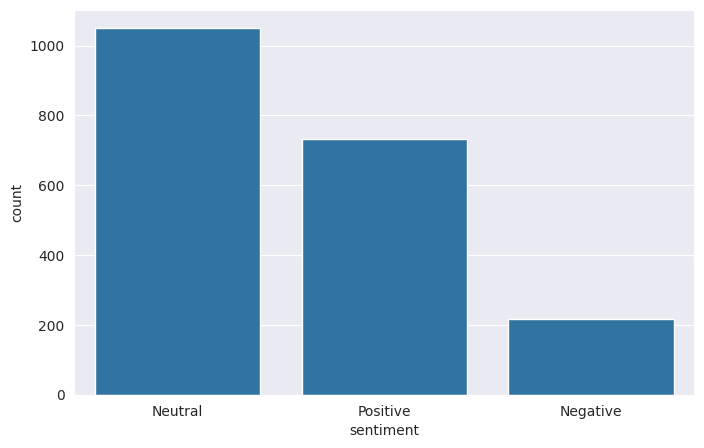

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='sentiment')

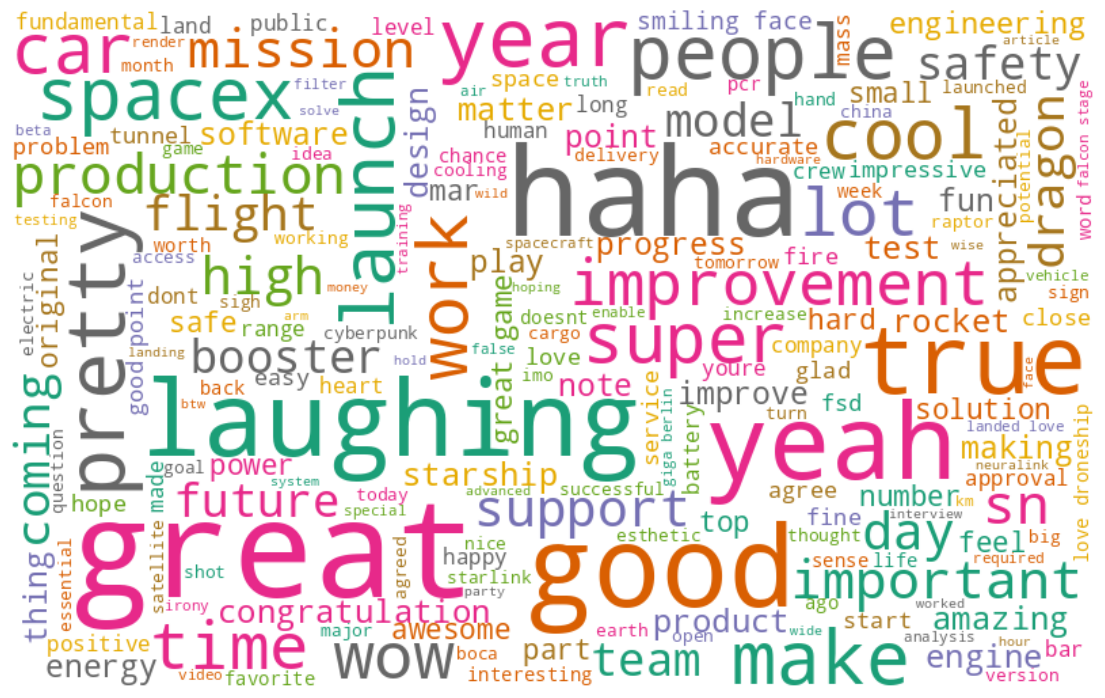

In [ ]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2',background_color='white').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

all_words = ' '.join([text for text in df[df['sentiment']=='Positive']['lemmatized_tweet']])
generate_wordcloud(all_words)

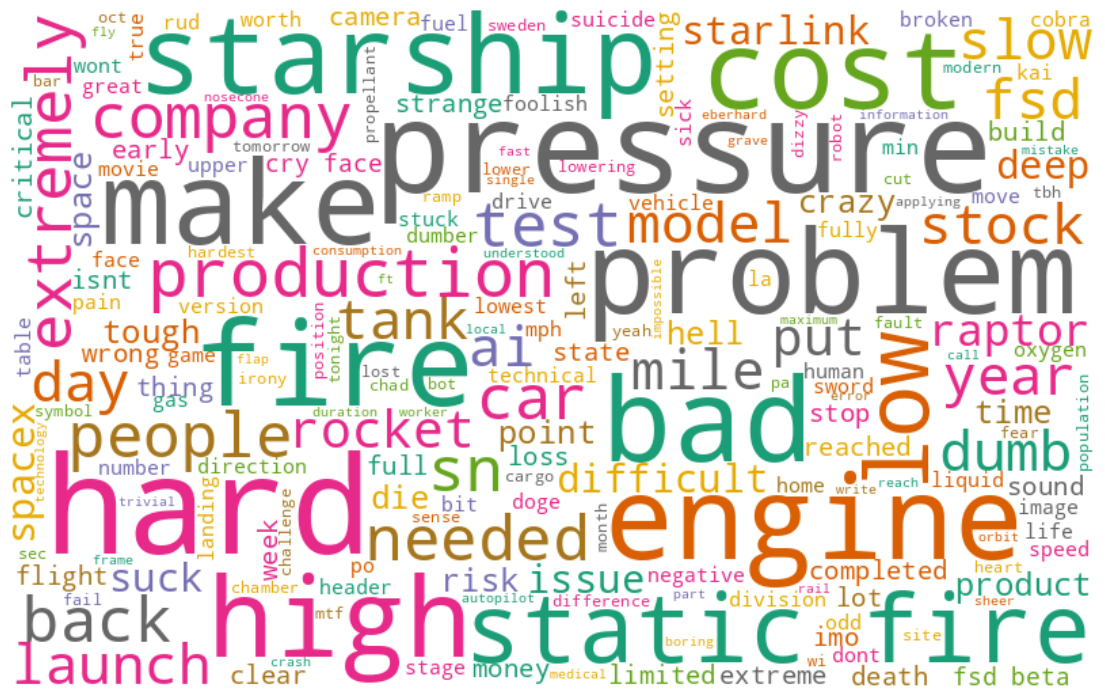

In [ ]:
all_words = ' '.join([text for text in df[df['sentiment']=='Negative']['lemmatized_tweet']])
generate_wordcloud(all_words)

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
tfidf_features = vectorizer.fit_transform(df['lemmatized_tweet'])
tfidf_df = pd.DataFrame(tfidf_features.toarray(),
                        columns=vectorizer.get_feature_names_out())

In [ ]:
tfidf_df.head()

,abort,absolutely,absurd,acceptable,access,accurate,achieve,active,actual,add,...,ya,yeah,year,yesterday,youd,youre,youve,yup,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.394729,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
target_variable = df['sentiment'].apply(lambda x: 0 if x=='Negative' else 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df,target_variable,test_size=0.3,random_state=42)

In [ ]:
classifier = MultinomialNB()
classifier.fit(x_train,y_train)

MultinomialNB()

In [ ]:
y_pred = classifier.predict(x_test)

In [ ]:
confusion_matrix(y_test,y_pred,labels=[True,False])

array([[539,   1],
       [ 58,   2]])

In [ ]:
accuracy_score(y_test,y_pred)*100

90.16666666666666